In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# 1. 准备数据
transform = transforms.Compose([
    transforms.ToTensor(),          # 转成tensor
    transforms.Normalize((0.5,), (0.5,))  # 标准化到[-1, 1]
])

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 60000
Test samples: 10000


In [9]:
image, label = train_dataset[0]
print(image.shape)
print(label)

torch.Size([1, 28, 28])
5


In [10]:
# 2. 定义CNN模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 输入通道1，输出通道16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # 16 -> 32
        self.fc1 = nn.Linear(32*7*7, 128)  # 7x7是经过两次池化后的尺寸
        self.fc2 = nn.Linear(128, 10)      # 10个数字类别

    def forward(self, x):
        x = F.relu(self.conv1(x))      # (batch, 16, 28, 28)
        x = F.max_pool2d(x, 2)          # (batch, 16, 14, 14)
        x = F.relu(self.conv2(x))       # (batch, 32, 14, 14)
        x = F.max_pool2d(x, 2)          # (batch, 32, 7, 7)
        x = x.view(x.size(0), -1)        # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
# 3. 定义损失和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# 4. 训练模型
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

Epoch [1/5], Loss: 0.2141
Epoch [2/5], Loss: 0.0567
Epoch [3/5], Loss: 0.0384
Epoch [4/5], Loss: 0.0296
Epoch [5/5], Loss: 0.0237
Training complete!


In [13]:
# 5. 测试模型
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.33%


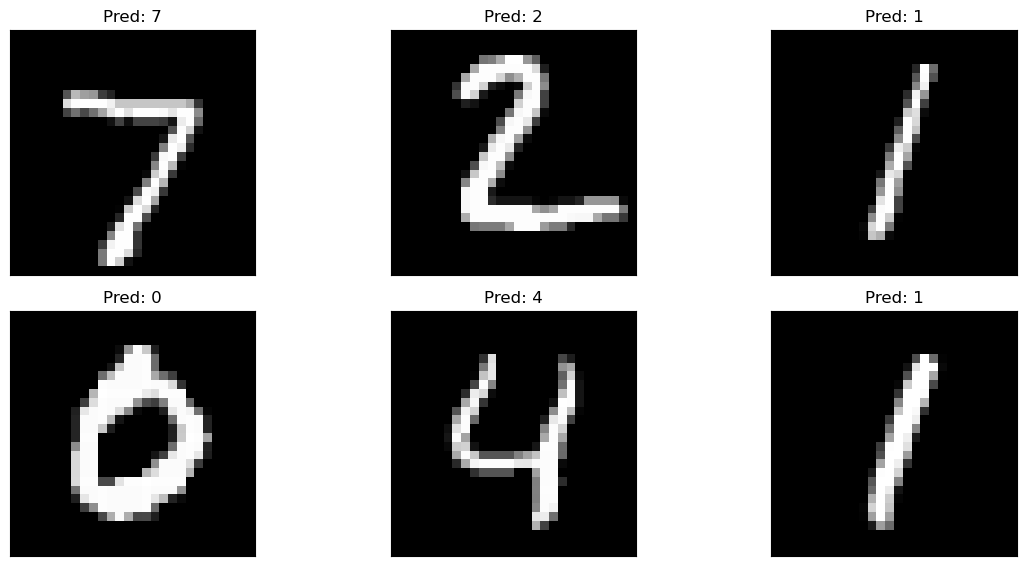

In [14]:
# 6. 可视化部分测试样本预测
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
    output = model(example_data)

fig = plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Pred: {output.argmax(dim=1)[i].item()}")
    plt.xticks([])
    plt.yticks([])
plt.show()